In [211]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr  # ou pearsonr
from sklearn.calibration import calibration_curve
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
df = pd.read_csv('/content/drive/My Drive/LSTMhmmdata.csv', index_col=0)

In [213]:
print(f"Shape du dataset: {df.shape}")
print(f"Colonnes: {df.columns.tolist()}")

Shape du dataset: (3878, 29)
Colonnes: ['volume', 'ADX', 'APO', 'CCI', 'MACD_Signal', 'MACD_Hist', 'OBV', 'RSI', 'SlowD', 'WMA', 'day_var_range', 'Bband_width', 'day_diff', 'ATR', 'day_cos', 'target', 'last_target', 'hmm_state', 'hmm_prob_state_0', 'hmm_prob_state_1', 'hmm_prob_state_2', 'hmm_prob_state_3', 'hmm_prob_state_4', 'hmm_prob_state_5', 'hmm_prob_state_6', 'hmm_entropy', 'hmm_max_prob', 'hmm_state_changed', 'hmm_state_duration']


In [214]:
df.columns

Index(['volume', 'ADX', 'APO', 'CCI', 'MACD_Signal', 'MACD_Hist', 'OBV', 'RSI',
       'SlowD', 'WMA', 'day_var_range', 'Bband_width', 'day_diff', 'ATR',
       'day_cos', 'target', 'last_target', 'hmm_state', 'hmm_prob_state_0',
       'hmm_prob_state_1', 'hmm_prob_state_2', 'hmm_prob_state_3',
       'hmm_prob_state_4', 'hmm_prob_state_5', 'hmm_prob_state_6',
       'hmm_entropy', 'hmm_max_prob', 'hmm_state_changed',
       'hmm_state_duration'],
      dtype='object')

In [215]:
if 'target' in df.columns:
    print(f"\nDistribution de la target:")
    print(df['target'].value_counts())
    print(f"Ratio: {df['target'].value_counts(normalize=True)}")
else:
    print("\n⚠️ ERREUR: Colonne 'target' non trouvée!")


Distribution de la target:
target
1    2003
0    1875
Name: count, dtype: int64
Ratio: target
1    0.516503
0    0.483497
Name: proportion, dtype: float64


In [216]:
# Séparer features et target
X = df.drop('target', axis=1)
y = df['target'].values

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Nombre de features: {X.shape[1]}")

# Vérifier les valeurs manquantes
if X.isnull().sum().sum() > 0:
    print(f"\n⚠️ Valeurs manquantes détectées: {X.isnull().sum().sum()}")
    X = X.fillna(method='ffill').fillna(method='bfill')
    print("✓ Valeurs manquantes remplies")

# Remplacer les infinis
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())


Features shape: (3878, 28)
Target shape: (3878,)
Nombre de features: 28


In [217]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✓ Données normalisées")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")
print(f"  Min: {X_scaled.min():.6f}")
print(f"  Max: {X_scaled.max():.6f}")


✓ Données normalisées
  Mean: -0.000000
  Std: 1.000000
  Min: -7.120120
  Max: 10.901757


In [218]:
def create_sequences(data, target, sequence_length):
    X_seq = []
    y_seq = []

    for i in range(sequence_length, len(data)):
        # Prendre les sequence_length derniers points
        X_seq.append(data[i-sequence_length:i])
        # Prédire le point suivant
        y_seq.append(target[i])

    return np.array(X_seq), np.array(y_seq)

# Paramètre: longueur de la séquence (lookback)
SEQUENCE_LENGTH = 60  # Utiliser les 60 derniers points pour prédire le suivant

print(f"Longueur de séquence (lookback): {SEQUENCE_LENGTH}")

X_sequences, y_sequences = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

print(f"\n✓ Séquences créées")
print(f"  X_sequences shape: {X_sequences.shape}")
print(f"  y_sequences shape: {y_sequences.shape}")
print(f"  Format: (n_sequences={X_sequences.shape[0]}, lookback={X_sequences.shape[1]}, n_features={X_sequences.shape[2]})")

Longueur de séquence (lookback): 60

✓ Séquences créées
  X_sequences shape: (3818, 60, 28)
  y_sequences shape: (3818,)
  Format: (n_sequences=3818, lookback=60, n_features=28)


In [219]:

# IMPORTANT: Split temporel, pas aléatoire!
# 70% train, 15% validation, 15% test
train_size = int(0.80 * len(X_sequences))
val_size = int(0.10 * len(X_sequences))

X_train = X_sequences[:train_size]
y_train = y_sequences[:train_size]

X_val = X_sequences[train_size:train_size+val_size]
y_val = y_sequences[train_size:train_size+val_size]

X_test = X_sequences[train_size+val_size:]
y_test = y_sequences[train_size+val_size:]

print(f"\n✓ Split temporel effectué:")
print(f"  Train: {X_train.shape[0]} samples ({train_size/len(X_sequences)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({val_size/len(X_sequences)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} samples ({(len(X_sequences)-train_size-val_size)/len(X_sequences)*100:.1f}%)")

print(f"\nDistribution train:")
print(f"  Down (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Up (1):   {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

print(f"\nDistribution test:")
print(f"  Down (0): {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Up (1):   {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")


✓ Split temporel effectué:
  Train: 3054 samples (80.0%)
  Val:   381 samples (10.0%)
  Test:  383 samples (10.0%)

Distribution train:
  Down (0): 1468 (48.1%)
  Up (1):   1586 (51.9%)

Distribution test:
  Down (0): 184 (48.0%)
  Up (1):   199 (52.0%)


In [220]:
def build_lstm_model(input_shape, learning_rate=0.001):
    """
    Construit un modèle LSTM pour classification binaire

    Args:
        input_shape: (sequence_length, n_features)
        learning_rate: Taux d'apprentissage

    Returns:
        model: Modèle Keras compilé
    """
    model = keras.Sequential([
        # Première couche LSTM avec return_sequences=True pour empiler
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),

        # Deuxième couche LSTM
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.3),

        # Troisième couche LSTM (dernière)
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.3),

        # Couches denses
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(16, activation='relu'),

        # Couche de sortie (classification binaire)
        layers.Dense(1, activation='sigmoid')
    ], name='LSTM_Trading_Model')

    # Compiler le modèle
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )

    return model

In [221]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)
model = build_lstm_model(input_shape, learning_rate=0.001)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [222]:
model.summary()

print(f"\nNombre total de paramètres: {model.count_params():,}")

Model: "LSTM_Trading_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 60, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,809 (561.75 KB)

 Trainable params: 143,809 (561.75 KB)

 Non-trainable params: 0 (0.00 B)


Nombre total de paramètres: 143,809


In [223]:
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# Réduction du learning rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Checkpoint pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stop, reduce_lr, checkpoint]


In [224]:
class_weight = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}

print(f"\nPoids de classe:")
print(f"  Down (0): {class_weight[0]:.4f}")
print(f"  Up (1):   {class_weight[1]:.4f}")

# Entraîner le modèle
EPOCHS = 100
BATCH_SIZE = 32

print(f"\nDébut de l'entraînement...")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks_list,
    verbose=1
)



Poids de classe:
  Down (0): 1.0402
  Up (1):   0.9628

Début de l'entraînement...
  Epochs: 100
  Batch size: 32
Epoch 1/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4973 - auc: 0.4999 - loss: 0.6982 - precision: 0.5118 - recall: 0.5418
Epoch 1: val_accuracy improved from -inf to 0.47507, saving model to best_lstm_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4969 - auc: 0.4992 - loss: 0.6982 - precision: 0.5115 - recall: 0.5377 - val_accuracy: 0.4751 - val_auc: 0.4757 - val_loss: 0.6959 - val_precision: 0.3846 - val_recall: 0.0785 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5176 - auc: 0.5250 - loss: 0.6919 - precision: 0.5443 - recall: 0.4073
Epoch 2: val_accuracy improved from 0.47507 to 0.50919, saving model to best_lstm_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5174 - auc: 0.5248 - loss: 0.6920 - precision: 0.5441 - recall: 0.4074 - val_accuracy: 0.5092 - val_auc: 0.5162 - val_loss: 0.6940 - val_precision: 0.5667 - val_recall: 0.0890 - learning_rate: 0.0010
Epoch 3/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5198 - auc: 0.5314 - loss: 0.6910 - precision: 0.5476 - recall: 0.3602
Epoch 3: val_accuracy did not improve from 0.50919
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5195 - auc: 0.5312 - loss: 0.6910 - precision: 0.5475 - recall: 0.3603 - val_accuracy: 0.4934 - val_auc: 0.4745 - val_loss: 0.6964 - val_precision: 0.4944 - val_recall: 0.4660 - learning_rate: 0.0010
Epoch 4/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5024 - auc: 0.5162 - loss: 0.6944 - precision: 0.5130 - recall: 0.4543
Epoch 4: val_accuracy did not improve from 0.50919
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5030 - auc: 0.5166 - loss: 0.6943 - precision: 0.5142 - recall

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5349 - auc: 0.5606 - loss: 0.6844 - precision: 0.5876 - recall: 0.3732 - val_accuracy: 0.5118 - val_auc: 0.4907 - val_loss: 0.7173 - val_precision: 0.5194 - val_recall: 0.3508 - learning_rate: 1.2500e-04
Epoch 22/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5695 - auc: 0.5854 - loss: 0.6793 - precision: 0.6416 - recall: 0.3956
Epoch 22: val_accuracy did not improve from 0.51181
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5692 - auc: 0.5853 - loss: 0.6793 - precision: 0.6413 - recall: 0.3952 - val_accuracy: 0.5092 - val_auc: 0.4887 - val_loss: 0.7161 - val_precision: 0.5154 - val_recall: 0.3508 - learning_rate: 1.2500e-04
Epoch 23/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5382 - auc: 0.5655 - loss: 0.6824 - precision: 0.6122 - recall: 0.3346
Epoch 23: val_accuracy did not improve from 0.51181
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5383 - auc: 0.5657 - loss: 0.6823 - precision: 0.6

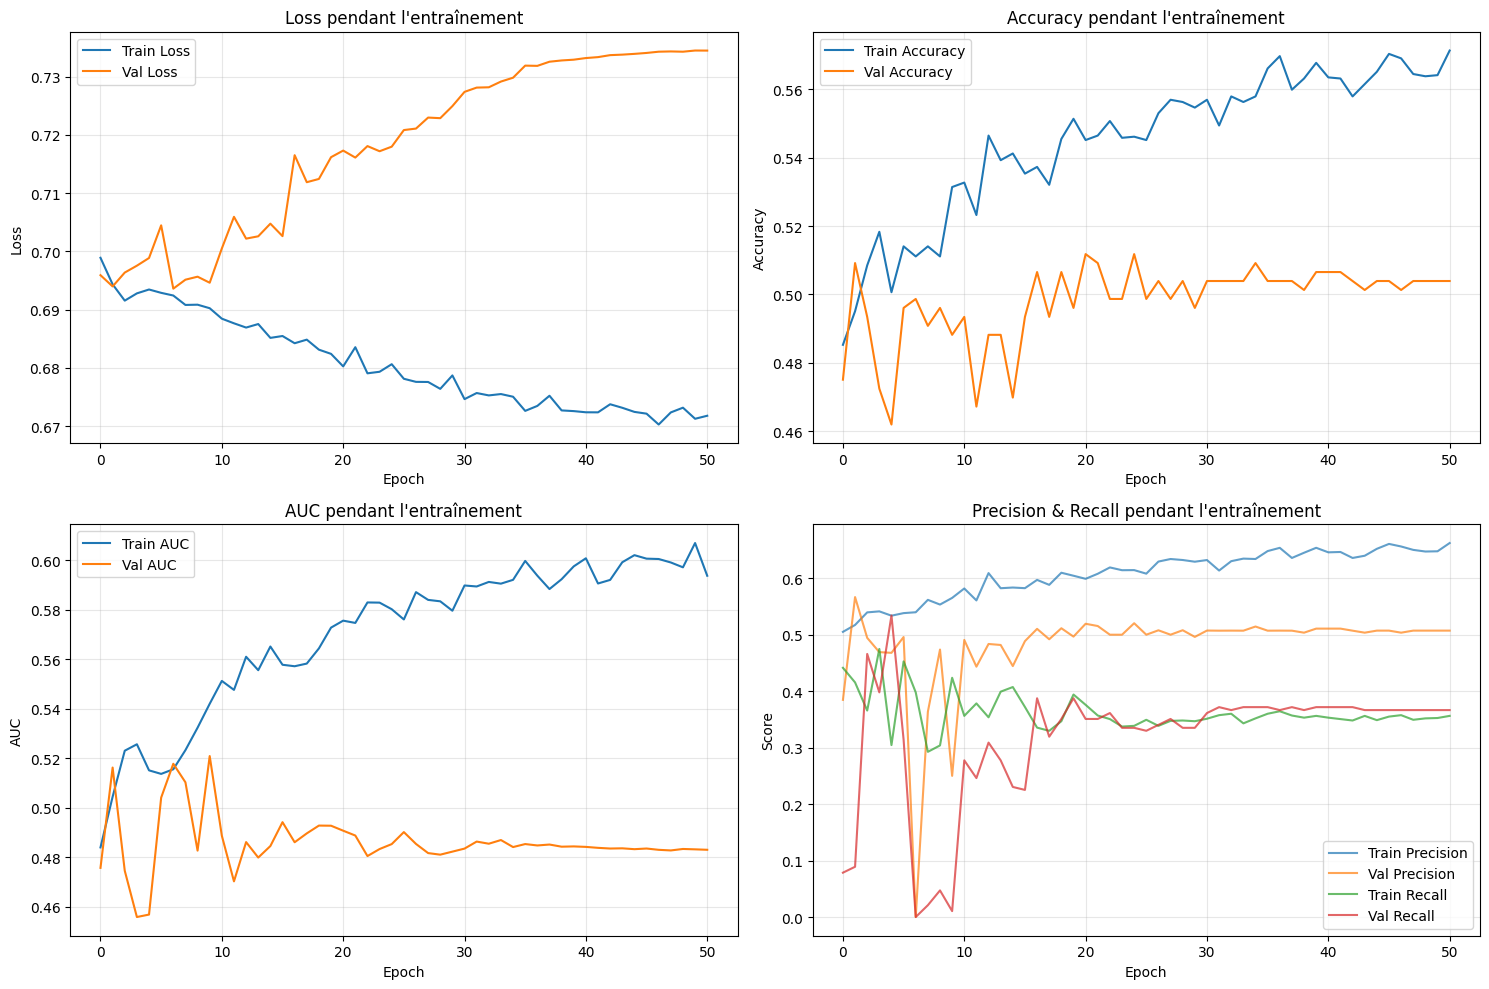

In [225]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss pendant l\'entraînement')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy pendant l\'entraînement')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC')
axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('AUC pendant l\'entraînement')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', alpha=0.7)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', alpha=0.7)
axes[1, 1].plot(history.history['recall'], label='Train Recall', alpha=0.7)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Precision & Recall pendant l\'entraînement')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [226]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

In [227]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 RÉSULTATS SUR TEST SET:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  AUC-ROC:   {auc_score:.4f}")

# Classification report détaillé
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down (0)', 'Up (1)']))


📊 RÉSULTATS SUR TEST SET:
  Accuracy:  0.5614
  Precision: 0.6099
  Recall:    0.4322
  F1-Score:  0.5059
  AUC-ROC:   0.5682

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.53      0.70      0.61       184
      Up (1)       0.61      0.43      0.51       199

    accuracy                           0.56       383
   macro avg       0.57      0.57      0.56       383
weighted avg       0.57      0.56      0.55       383



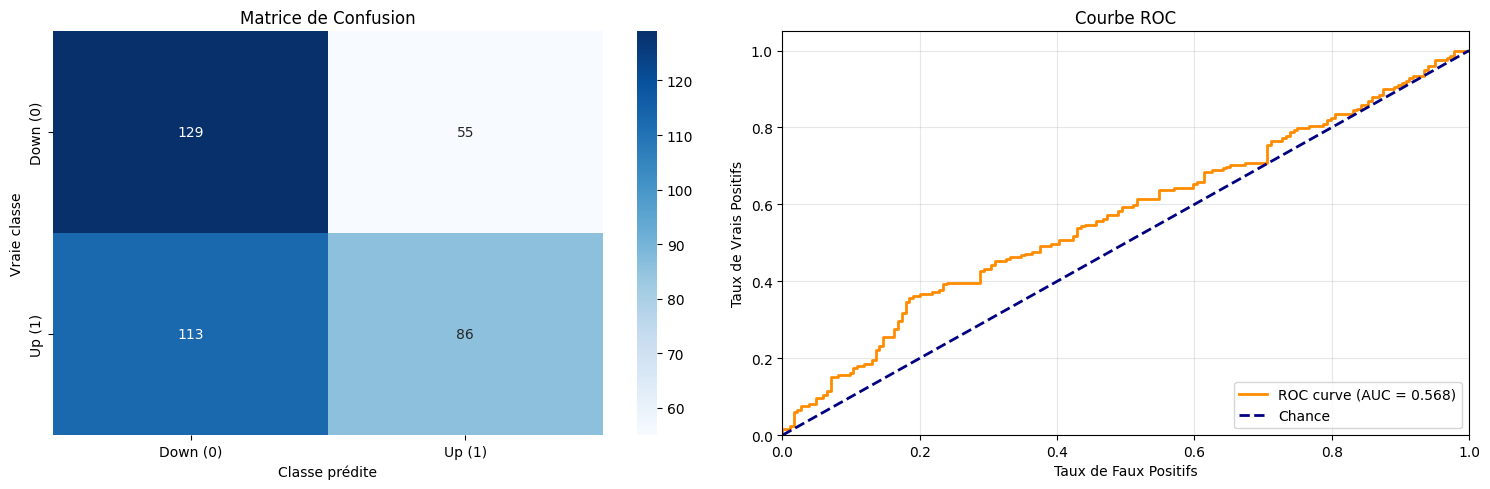

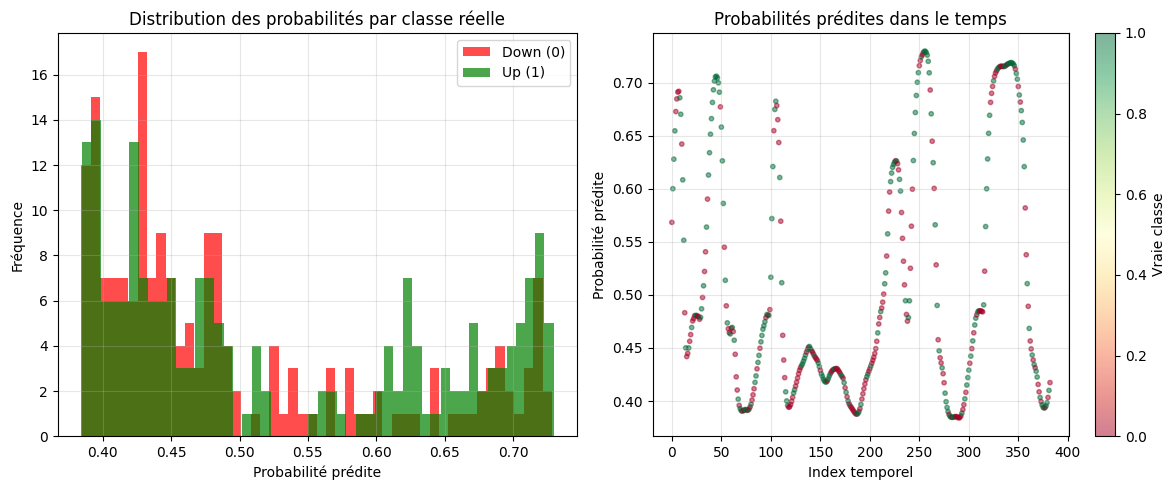

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'],
            ax=axes[0])
axes[0].set_title('Matrice de Confusion')
axes[0].set_ylabel('Vraie classe')
axes[0].set_xlabel('Classe prédite')

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taux de Faux Positifs')
axes[1].set_ylabel('Taux de Vrais Positifs')
axes[1].set_title('Courbe ROC')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution des probabilités prédites
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Down (0)', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Up (1)', color='green')
plt.xlabel('Probabilité prédite')
plt.ylabel('Fréquence')
plt.title('Distribution des probabilités par classe réelle')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred_proba, c=y_test, cmap='RdYlGn', alpha=0.5, s=10)
plt.xlabel('Index temporel')
plt.ylabel('Probabilité prédite')
plt.title('Probabilités prédites dans le temps')
plt.colorbar(label='Vraie classe')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



MÉTHODE SIMPLIFIÉE: Moyenne des poids absolus

📊 TOP 20 FEATURES LES PLUS IMPORTANTES (méthode simplifiée):
         feature  importance_simple
             WMA           0.065330
       MACD_Hist           0.062423
             APO           0.061365
     MACD_Signal           0.060685
          volume           0.058666
hmm_prob_state_5           0.053906
hmm_prob_state_2           0.048311
hmm_prob_state_3           0.047614
     last_target           0.042751
         day_cos           0.039276
             CCI           0.037085
           SlowD           0.035753
             ADX           0.034919
        day_diff           0.033846
             RSI           0.033026
     Bband_width           0.032145
   day_var_range           0.026200
             ATR           0.025199
     hmm_entropy           0.024381
hmm_prob_state_0           0.023555


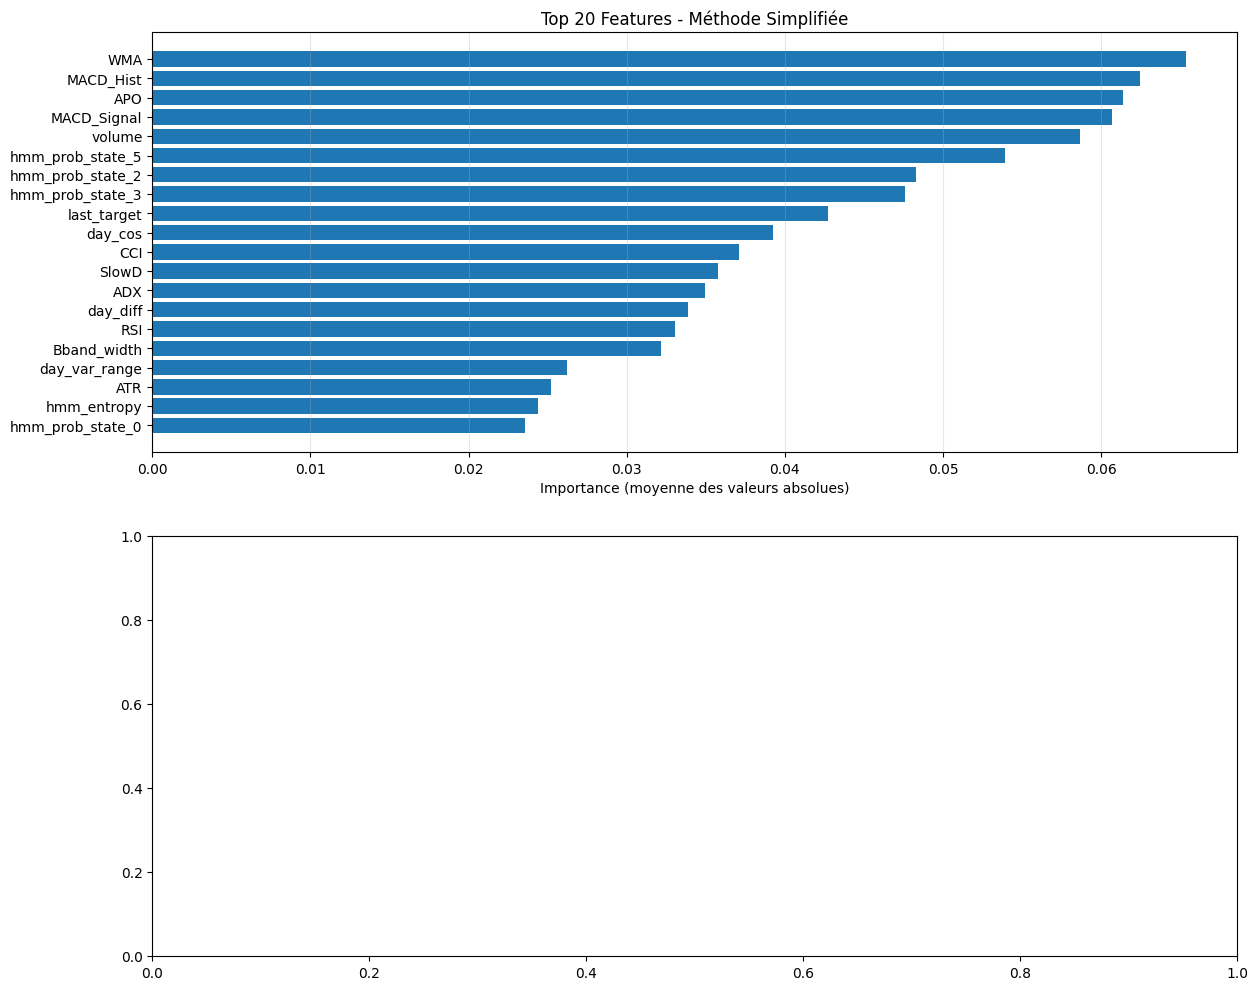

In [229]:
# MÉTHODE 2: Calcul simplifié - Variance des features sur toute la séquence
print("\n" + "="*60)
print("MÉTHODE SIMPLIFIÉE: Moyenne des poids absolus")
print("="*60)

# Pour chaque feature, calculer sa contribution moyenne
# On moyenne sur toutes les positions temporelles (sequence_length)
feature_importance_simple = np.abs(X_test).mean(axis=(0, 1))  # Moyenne sur samples et temps

# Normaliser
feature_importance_simple = feature_importance_simple / feature_importance_simple.sum()

# Créer un DataFrame avec les résultats
feature_names = X.columns.tolist()
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_simple': feature_importance_simple,
})

# Trier par importance
importance_df = importance_df.sort_values('importance_simple', ascending=False)

print("\n📊 TOP 20 FEATURES LES PLUS IMPORTANTES (méthode simplifiée):")
print(importance_df.head(20).to_string(index=False))

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 20 features - méthode simple
top_20_simple = importance_df.head(20)
axes[0].barh(range(len(top_20_simple)), top_20_simple['importance_simple'])
axes[0].set_yticks(range(len(top_20_simple)))
axes[0].set_yticklabels(top_20_simple['feature'])
axes[0].set_xlabel('Importance (moyenne des valeurs absolues)')
axes[0].set_title('Top 20 Features - Méthode Simplifiée')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')
